In this section, we start by importing the necessary libraries for data manipulation and visualization. We then load the datasets containing historical weather in Central Park (NYC). To get an initial understanding of the data, we display the first few rows of each dataset. This step helps us verify that the data has been loaded correctly and allows us to inspect the structure and contents of the datasets.

In [27]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt

# Load the dataset
weather_df = pd.read_csv('NYC_Central_Park_weather_1869-2022.csv')

# Display the first few rows of the dataset
print("Weather Dataset:")
print(weather_df.head())

# Drop the 'SNWD' column
weather_df = weather_df.drop(columns=['SNWD'])


Weather Dataset:
         DATE  PRCP  SNOW  SNWD  TMIN  TMAX
0  1869-01-01  0.75   9.0   NaN  19.0  29.0
1  1869-01-02  0.03   0.0   NaN  21.0  27.0
2  1869-01-03  0.00   0.0   NaN  27.0  35.0
3  1869-01-04  0.18   0.0   NaN  34.0  37.0
4  1869-01-05  0.05   0.0   NaN  37.0  43.0


In this step, we preprocess the dataset to prepare them for analysis. We start by converting the date columns to datetime objects to facilitate time series operations. Next, we set these date columns as the index for both datasets, ensuring that the data is properly organized by time. To handle any potential missing values, we use forward filling to propagate the last valid observation forward. Finally, we display the first few rows of each dataset after preprocessing to confirm that the changes have been applied correctly.








In [28]:
# Convert date column to datetime
weather_df['DATE'] = pd.to_datetime(weather_df['DATE'])

# Set the date column as the index
weather_df.set_index('DATE', inplace=True)

# Handle missing values (if any) by forward filling
weather_df.fillna(method='ffill', inplace=True)

# Display the first few rows after preprocessing
print("Weather Dataset after preprocessing:")
print(weather_df.head())

Weather Dataset after preprocessing:
            PRCP  SNOW  TMIN  TMAX
DATE                              
1869-01-01  0.75   9.0  19.0  29.0
1869-01-02  0.03   0.0  21.0  27.0
1869-01-03  0.00   0.0  27.0  35.0
1869-01-04  0.18   0.0  34.0  37.0
1869-01-05  0.05   0.0  37.0  43.0


In this section, we visualize the historical weather data to understand their trends over time.

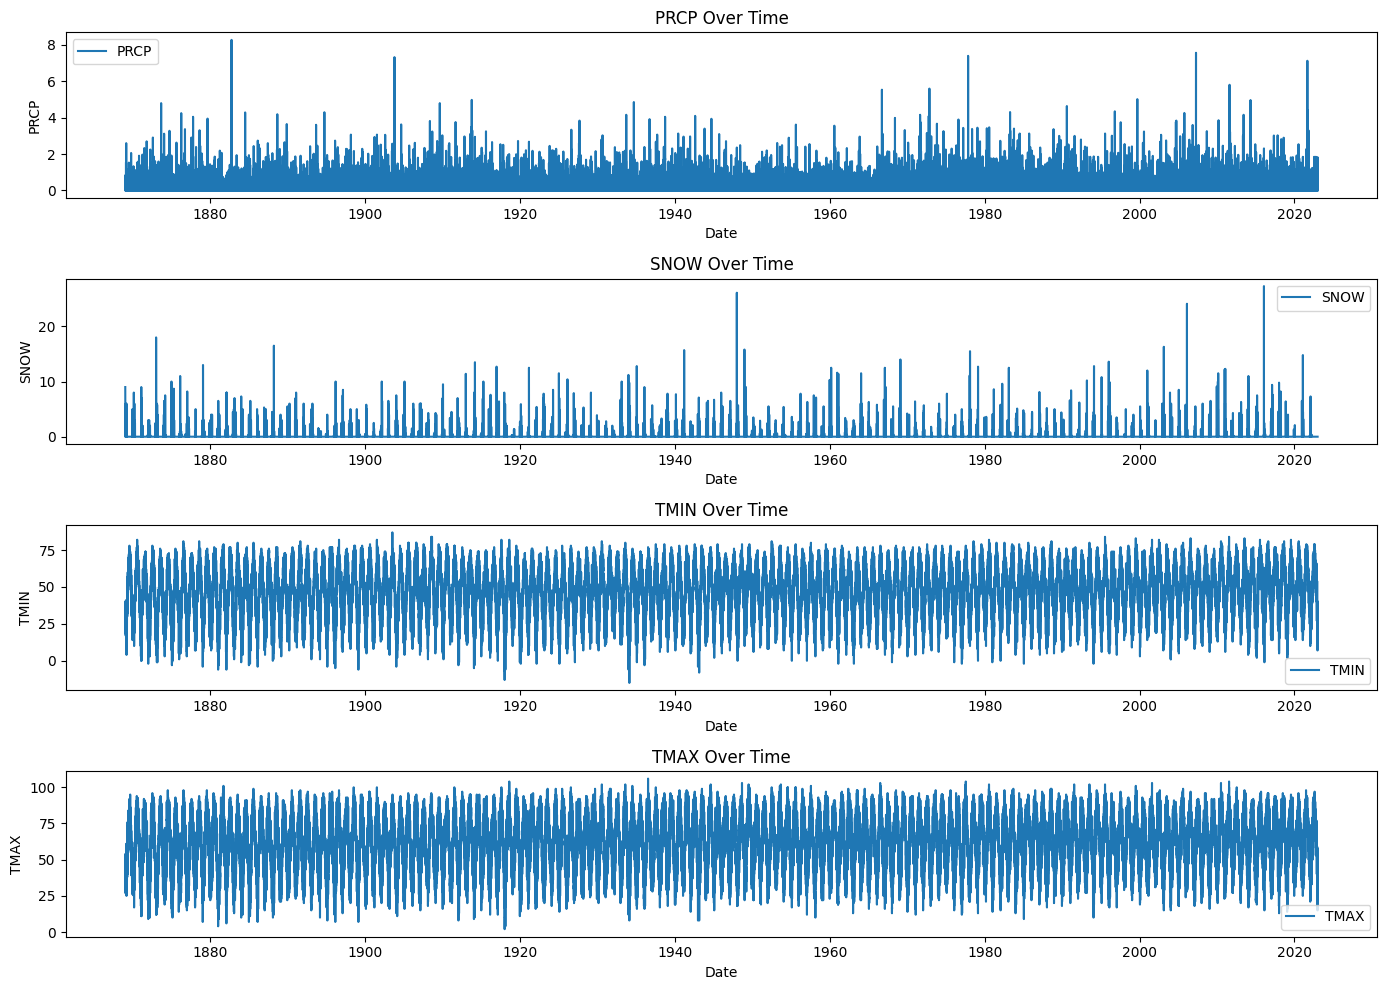

In [3]:
# Plot the time series data
plt.figure(figsize=(14, 10))

for i, column in enumerate(weather_df.columns, 1):
    plt.subplot(len(weather_df.columns), 1, i)
    plt.plot(weather_df.index, weather_df[column], label=column)
    plt.title(f'{column} Over Time')
    plt.xlabel('Date')
    plt.ylabel(column)
    plt.legend()

plt.tight_layout()
plt.show()

In this step, we perform a correlation analysis and autocorrelation analysis of the time series. First, we calculate the correlation matrix between the four time series to quantify the strength and direction of their linear relationship.
Next, we generate autocorrelation plots for the min temperature. Autocorrelation plots help us understand the internal structure of the time series data by showing how each value in the series is correlated with previous values (lags).

Correlation Matrix:
          PRCP      SNOW      TMIN      TMAX
PRCP  1.000000  0.166243  0.053290  0.000127
SNOW  0.166243  1.000000 -0.172172 -0.183538
TMIN  0.053290 -0.172172  1.000000  0.953828
TMAX  0.000127 -0.183538  0.953828  1.000000


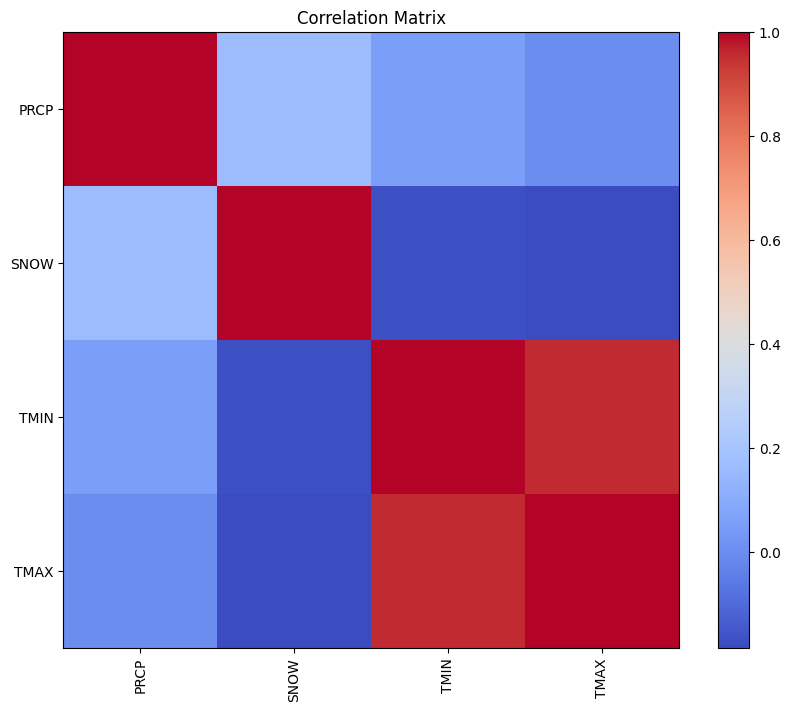

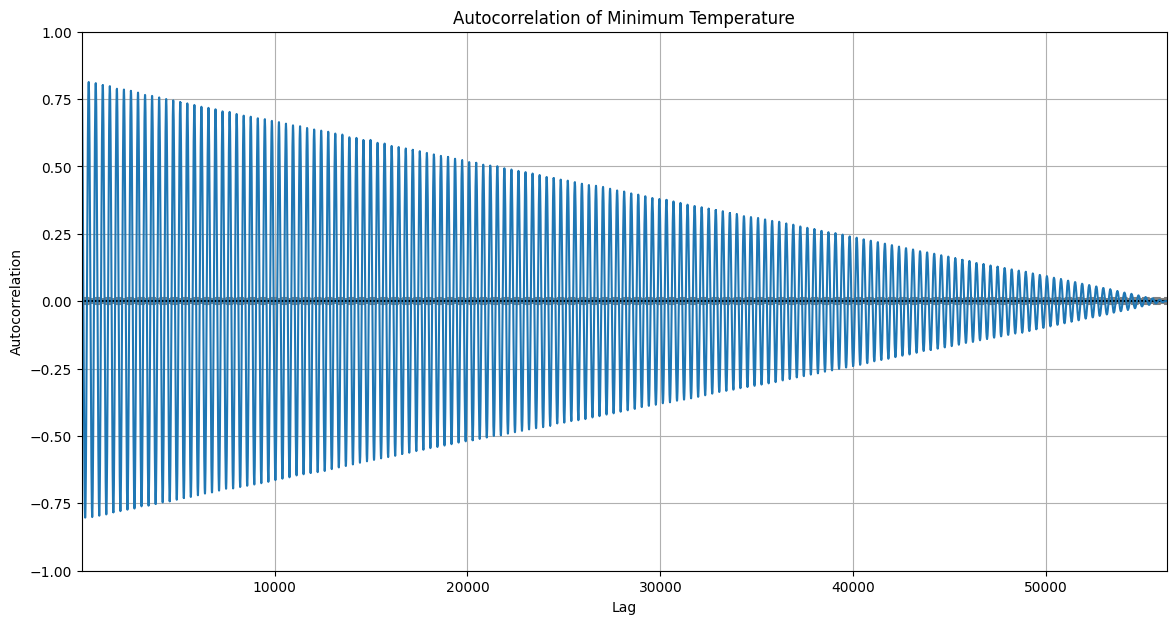

In [5]:
# Compute the correlation matrix
correlation_matrix = weather_df.corr()
print("Correlation Matrix:")
print(correlation_matrix)

# Plot the correlation matrix
plt.figure(figsize=(10, 8))
plt.imshow(correlation_matrix, cmap='coolwarm', interpolation='none')
plt.colorbar()
plt.xticks(range(len(correlation_matrix)), correlation_matrix.columns, rotation=90)
plt.yticks(range(len(correlation_matrix)), correlation_matrix.columns)
plt.title('Correlation Matrix')
plt.show()

# Autocorrelation plot for Minimum Temperature
from pandas.plotting import autocorrelation_plot

plt.figure(figsize=(14, 7))
autocorrelation_plot(weather_df['TMIN'])
plt.title('Autocorrelation of Minimum Temperature')
plt.show()

In this section, we prepare the min temperature data for training a Recurrent Neural Network (RNN). First, we normalize the temperature data to scale the values between 0 and 1.

Next, we define a function to create sequences of input data and corresponding target values for the RNN. We use a sliding window approach to generate these sequences, where each input sequence consists of the last 360 days of data, and the target is the min temperature for the next 60 days.

We then split the dataset into training, validation, and test sets.

In [29]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# Normalize the TMIN data
scaler = MinMaxScaler()
weather_df['TMIN'] = scaler.fit_transform(weather_df[['TMIN']])

# Prepare the data for training the RNN
def create_sequences(data, input_length, output_length):
    xs, ys = [], []
    for i in range(len(data) - input_length - output_length + 1):
        x = data[i:i+input_length]
        y = data[i+input_length:i+input_length+output_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

# Parameters
input_length = 360  # Last year
output_length = 60  # Forecast 60 days ahead

# Create sequences
data = weather_df['TMIN'].values
X, y = create_sequences(data, input_length, output_length)

# Split the data into training, validation, and test sets
train_size = int(len(X) * 0.8)
val_size = int(len(X) * 0.1875)

X_train, y_train = X[:train_size], y[:train_size]
X_val, y_val = X[train_size:train_size + val_size], y[train_size:train_size + val_size]
X_test, y_test = X[train_size + val_size:], y[train_size + val_size:]

print(f"Training set size: {X_train.shape}")
print(f"Validation set size: {X_val.shape}")
print(f"Test set size: {X_test.shape}")

Training set size: (44660, 360)
Validation set size: (10467, 360)
Test set size: (699, 360)


In this section, we define a function to train the Recurrent Neural Network (RNN) model using the training and validation datasets. The function employs the Adam optimizer with a learning rate of 0.0001 and uses Mean Squared Error (MSE) as the loss function.

The training process involves several steps:

Training Loop: For each epoch, the model processes batches of training data, computes the loss, performs backpropagation, and updates the model parameters.
Validation Phase: After each training epoch, the model is evaluated on the validation set to monitor its performance and prevent overfitting.
Early Stopping: If the validation loss does not improve for a specified number of epochs (patience), the training process stops early, and the model reverts to the best weights observed during training.

In [7]:
import torch.optim as optim

def train_model(model, train_loader, val_loader, num_epochs=100, patience=10, lr=0.0001):
    criterion = nn.MSELoss()  # Mean Squared Error Loss
    optimizer = optim.Adam(model.parameters(), lr=0.0001)  # Adam optimizer

    best_loss = float('inf')
    epochs_no_improve = 0

    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        train_loss /= len(train_loader)
        train_losses.append(train_loss)

        # Validation phase
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                val_loss += loss.item()

        val_loss /= len(val_loader)
        val_losses.append(val_loss)

        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

        # Early stopping
        if val_loss < best_loss:
            best_loss = val_loss
            epochs_no_improve = 0
            best_model_wts = model.state_dict()
        else:
            epochs_no_improve += 1
            if epochs_no_improve == patience:
                print("Early stopping!")
                model.load_state_dict(best_model_wts)
                break

    return model, train_losses, val_losses

In this section, we define the architecture of our Recurrent Neural Network (RNN) model, which will be used to forecast future temperature in Central Park. The RNN model is constructed using PyTorch and includes the following key components:

Input Layer: The model takes in sequences temperatures, where each input sequence has one feature (the min temperature).

Hidden Layer(s): The RNN has multiple layers of hidden states. In our architecture, we use two hidden layers (num_layers=2) with 100 hidden units each (hidden_size=100). The hidden states allow the model to capture temporal dependencies in the data.

Recurrent Layer: The core of the RNN is the recurrent layer (self.rnn), which processes the input sequences and maintains the hidden states across time steps. The batch_first=True argument ensures that the input tensor shape is (batch_size, sequence_length, input_size).

Fully Connected Layer: The output from the last time step of the RNN is passed to a fully connected layer (self.fc), which maps the hidden state to the output size. In our case, the output size is 60, as we aim to predict temperature for the next two months.

The forward pass of the model initializes the hidden state (h0), processes the input through the RNN, and then uses the final hidden state to generate the output predictions.

In [10]:
import torch
import torch.nn as nn

class RNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(RNNModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)  # Initial hidden state
        out, _ = self.rnn(x, h0)  # Forward pass through RNN
        out = self.fc(out[:, -1, :])  # Decode the last hidden state
        return out

# Define model parameters
input_size = 1  # One feature (price)
hidden_size = 100
num_layers = 2
output_size = 60  # Predicting 1 months ahead

# Instantiate the model
model = RNNModel(input_size, hidden_size, num_layers, output_size)

In this section, we set up data loaders for training and validation, ensuring the input data has the correct shape for the RNN. The model is then moved to the appropriate device (GPU or CPU) for training. We train the model with early stopping and plot the training and validation losses over epochs to visualize the model's performance.

Epoch 1/20, Train Loss: 0.0055, Val Loss: 0.0054
Epoch 2/20, Train Loss: 0.0054, Val Loss: 0.0053
Epoch 3/20, Train Loss: 0.0054, Val Loss: 0.0053
Epoch 4/20, Train Loss: 0.0053, Val Loss: 0.0053
Epoch 5/20, Train Loss: 0.0054, Val Loss: 0.0053
Epoch 6/20, Train Loss: 0.0053, Val Loss: 0.0054
Epoch 7/20, Train Loss: 0.0054, Val Loss: 0.0052
Epoch 8/20, Train Loss: 0.0054, Val Loss: 0.0057
Epoch 9/20, Train Loss: 0.0054, Val Loss: 0.0054
Epoch 10/20, Train Loss: 0.0054, Val Loss: 0.0052
Epoch 11/20, Train Loss: 0.0053, Val Loss: 0.0054
Epoch 12/20, Train Loss: 0.0053, Val Loss: 0.0052
Epoch 13/20, Train Loss: 0.0054, Val Loss: 0.0053
Epoch 14/20, Train Loss: 0.0053, Val Loss: 0.0053
Epoch 15/20, Train Loss: 0.0053, Val Loss: 0.0057
Epoch 16/20, Train Loss: 0.0053, Val Loss: 0.0052
Epoch 17/20, Train Loss: 0.0054, Val Loss: 0.0051
Epoch 18/20, Train Loss: 0.0053, Val Loss: 0.0051
Epoch 19/20, Train Loss: 0.0053, Val Loss: 0.0052
Epoch 20/20, Train Loss: 0.0053, Val Loss: 0.0057


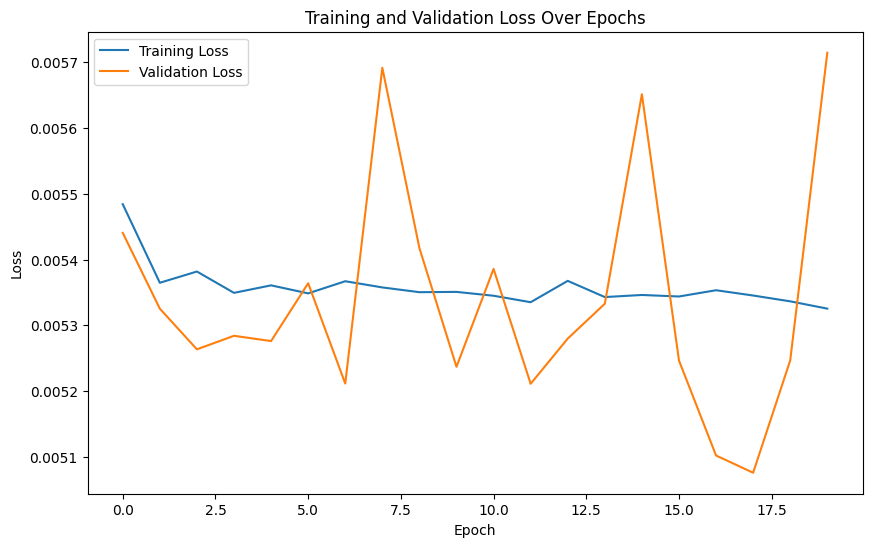

In [30]:
# Define data loaders
batch_size = 256

train_loader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(torch.tensor(X_train, dtype=torch.float32).unsqueeze(-1), torch.tensor(y_train, dtype=torch.float32)),
    batch_size=batch_size, shuffle=True
)

val_loader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(torch.tensor(X_val, dtype=torch.float32).unsqueeze(-1), torch.tensor(y_val, dtype=torch.float32)),
    batch_size=batch_size, shuffle=False
)

# Move model to device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# Train the model
trained_model, train_losses, val_losses = train_model(model, train_loader, val_loader, num_epochs=20, patience=5)

# Plot training and validation losses
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss Over Epochs')
plt.show()

In this section, we evaluate the trained RNN model on the test set. We collect the model's predictions and inverse transform them to their original scale. We then visualize the predicted vs. actual temperature and calculate performance metrics (MAE, RMSE, MAPE) to quantify the model's accuracy.

Predictions shape: (699, 60)
Targets shape: (699, 60)


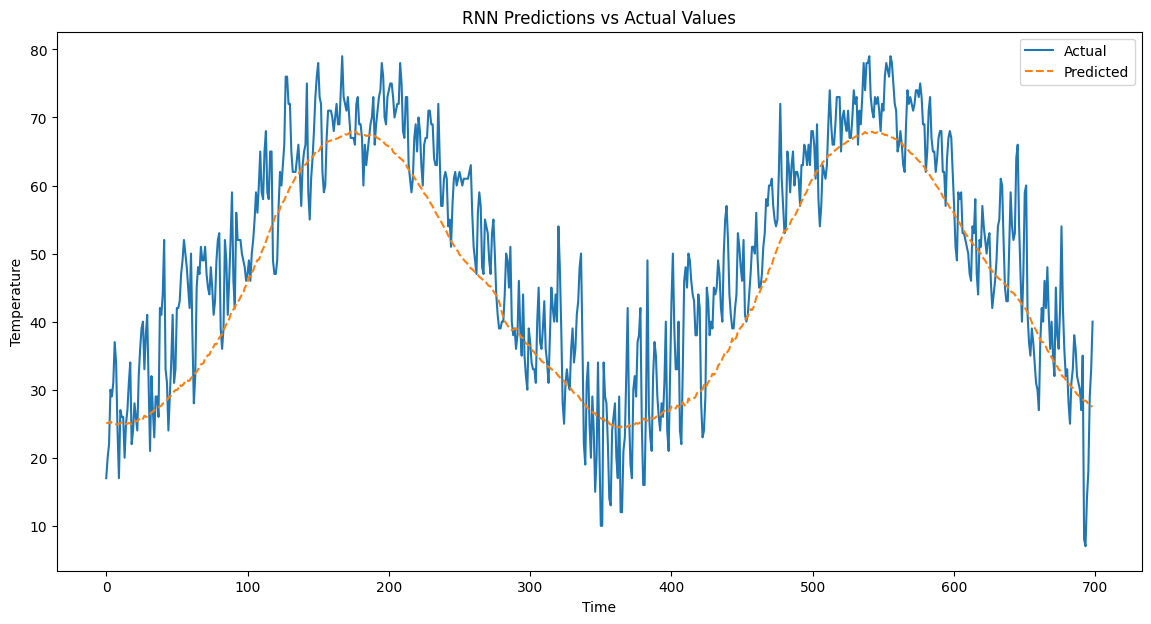

Mean Absolute Error (MAE): 6.7476
Root Mean Squared Error (RMSE): 8.4088
Mean Absolute Percentage Error (MAPE): 15.72%


In [32]:
# Test the model
trained_model.eval()
test_predictions = []
test_targets = []

with torch.no_grad():
    for inputs, targets in torch.utils.data.DataLoader(
        torch.utils.data.TensorDataset(torch.tensor(X_test, dtype=torch.float32).unsqueeze(-1), torch.tensor(y_test, dtype=torch.float32)),
        batch_size=batch_size, shuffle=False
    ):
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = trained_model(inputs)
        test_predictions.append(outputs.cpu().numpy())
        test_targets.append(targets.cpu().numpy())

# Flatten the lists
test_predictions = np.concatenate(test_predictions, axis=0)
test_targets = np.concatenate(test_targets, axis=0)

# Inverse transform the predictions and targets
test_predictions = scaler.inverse_transform(test_predictions)
test_targets = scaler.inverse_transform(test_targets)

# Print the shape of predictions and targets
print(f"Predictions shape: {test_predictions.shape}")
print(f"Targets shape: {test_targets.shape}")

# For visualization, let's use only the last prediction for each test sample
test_predictions_flat = test_predictions[:, -1]
test_targets_flat = test_targets[:, -1]

# Plot the predictions vs the real values
plt.figure(figsize=(14, 7))
plt.plot(test_targets_flat, label='Actual')
plt.plot(test_predictions_flat, label='Predicted', linestyle='--')
plt.title('RNN Predictions vs Actual Values')
plt.xlabel('Time')
plt.ylabel('Temperature')
plt.legend()
plt.show()

def calculate_metrics(y_true, y_pred):
    mae = np.mean(np.abs(y_true - y_pred))
    rmse = np.sqrt(np.mean((y_true - y_pred) ** 2))
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return mae, rmse, mape

# Calculate metrics for the test set
mae, rmse, mape = calculate_metrics(test_targets_flat, test_predictions_flat)
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")


In this section, we evaluate the performance of our trained RNN model on the test dataset. Specifically, we use the model to forecast the minimum temperature (TMIN) for the next 60 days using all available features as input. We plot the test data (excluding the last 10 points) in blue, the predicted next 10 days in red, and the actual last 10 days in green.

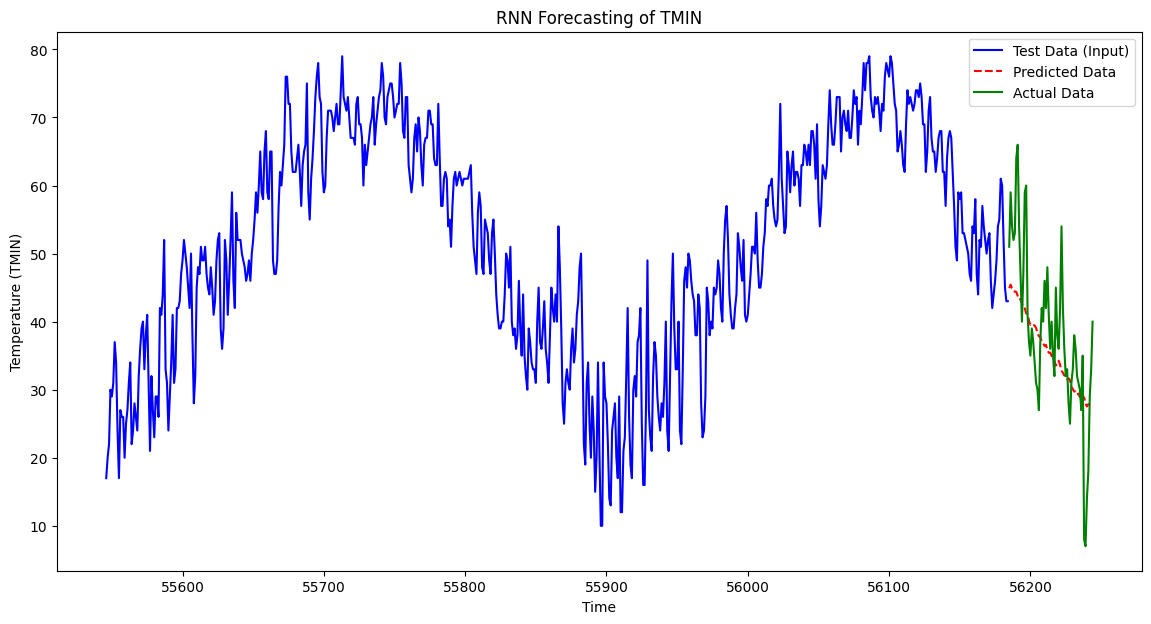

Mean Absolute Error (MAE): 7.1017
Root Mean Squared Error (RMSE): 9.2587
Mean Absolute Percentage Error (MAPE): 25.72%


In [37]:
# Test the model
trained_model.eval()
test_predictions = []

with torch.no_grad():
    # Load the last sequence of inputs for forecasting the next 60 points
    inputs = torch.tensor(X_test[-1:], dtype=torch.float32).unsqueeze(-1).to(device)
    outputs = trained_model(inputs)
    test_predictions = outputs.cpu().numpy()[0]

# Inverse transform the predictions
test_predictions_padded = np.zeros((test_predictions.shape[0], 1))
test_predictions_padded[:, 0] = test_predictions  # Use the prediction steps for TMIN
test_predictions_inv = scaler.inverse_transform(test_predictions_padded)[:, 0]

# Inverse transform the last 60 targets
test_targets_padded = np.zeros((y_test[-1].shape[0], 1))
test_targets_padded[:, 0] = y_test[-1]  # Use the target steps for TMIN
test_targets_inv = scaler.inverse_transform(test_targets_padded)[:, 0]

# Get the indices for plotting
test_indices = range(len(weather_df['TMIN']) - len(X_test), len(weather_df['TMIN']))
forecast_indices = range(len(weather_df['TMIN']) - 60, len(weather_df['TMIN']))

# Plot the data
plt.figure(figsize=(14, 7))

# Plot the test data except for the last 60 in blue
weather_df['TMIN'] = scaler.inverse_transform(weather_df[['TMIN']])
plt.plot(test_indices[:-60], weather_df['TMIN'].values[-len(X_test):-60], label='Test Data (Input)', color='blue')

# Plot the predicted next 60 data points in red
plt.plot(forecast_indices, test_predictions_inv, label='Predicted Data', color='red', linestyle='--')

# Plot the actual last 60 data points in green
plt.plot(forecast_indices, test_targets_inv, label='Actual Data', color='green')

plt.title('RNN Forecasting of TMIN')
plt.xlabel('Time')
plt.ylabel('Temperature (TMIN)')
plt.legend()
plt.show()

def calculate_metrics(y_true, y_pred):
    mae = np.mean(np.abs(y_true - y_pred))
    rmse = np.sqrt(np.mean((y_true - y_pred) ** 2))
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return mae, rmse, mape

# Calculate metrics for the last 10 predictions
mae, rmse, mape = calculate_metrics(test_targets_inv, test_predictions_inv)
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")

In this section, we define and train an LSTM model to forecast the temperature. The LSTM architecture includes two layers with 50 hidden units and a dropout rate of 0.3 to prevent overfitting. We then train the model using the same procedure as the RNN, and plot the training and validation losses over epochs to monitor the model's performance.








Epoch 1/20, Train Loss: 0.2711, Val Loss: 0.0544
Epoch 2/20, Train Loss: 0.0296, Val Loss: 0.0217
Epoch 3/20, Train Loss: 0.0208, Val Loss: 0.0169
Epoch 4/20, Train Loss: 0.0164, Val Loss: 0.0131
Epoch 5/20, Train Loss: 0.0133, Val Loss: 0.0096
Epoch 6/20, Train Loss: 0.0140, Val Loss: 0.0125
Epoch 7/20, Train Loss: 0.0106, Val Loss: 0.0074
Epoch 8/20, Train Loss: 0.0078, Val Loss: 0.0064
Epoch 9/20, Train Loss: 0.0070, Val Loss: 0.0061
Epoch 10/20, Train Loss: 0.0067, Val Loss: 0.0061
Epoch 11/20, Train Loss: 0.0065, Val Loss: 0.0059
Epoch 12/20, Train Loss: 0.0064, Val Loss: 0.0058
Epoch 13/20, Train Loss: 0.0063, Val Loss: 0.0057
Epoch 14/20, Train Loss: 0.0061, Val Loss: 0.0057
Epoch 15/20, Train Loss: 0.0061, Val Loss: 0.0058
Epoch 16/20, Train Loss: 0.0060, Val Loss: 0.0055
Epoch 17/20, Train Loss: 0.0060, Val Loss: 0.0057
Epoch 18/20, Train Loss: 0.0059, Val Loss: 0.0055
Epoch 19/20, Train Loss: 0.0058, Val Loss: 0.0055
Epoch 20/20, Train Loss: 0.0058, Val Loss: 0.0056


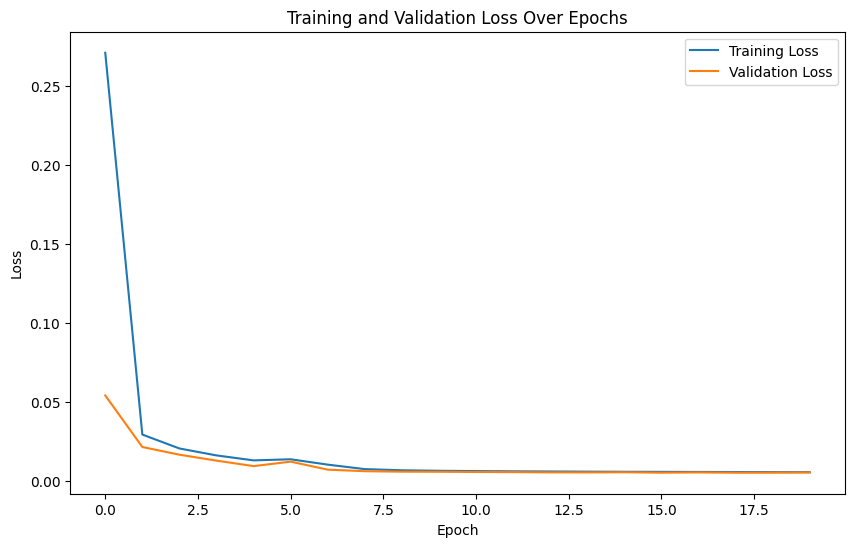

In [38]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=0.3)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)  # Initial hidden state
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)  # Initial cell state
        out, _ = self.lstm(x, (h0, c0))  # LSTM output and new hidden/cell states
        out = self.fc(out[:, -1, :])  # Use the output of the last time step
        return out

# Instantiate the LSTM model
lstm_model = LSTMModel(input_size=1, hidden_size=50, num_layers=2, output_size=60).to(device)

# Train the LSTM mod# Train the model
trained_lstm_model, train_losses, val_losses = train_model(lstm_model, train_loader, val_loader, num_epochs=20, patience=5, lr=0.001)

# Plot training and validation losses
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss Over Epochs')
plt.show()

In this section, we evaluate the performance of the trained LSTM model on the test set. We generate predictions and inverse transform them to their original scale. We then visualize the predicted vs. actual temperature and compute performance metrics (MAE, RMSE, MAPE) to assess the accuracy of the LSTM model.








Predictions shape: (699, 60)
Targets shape: (699, 60)


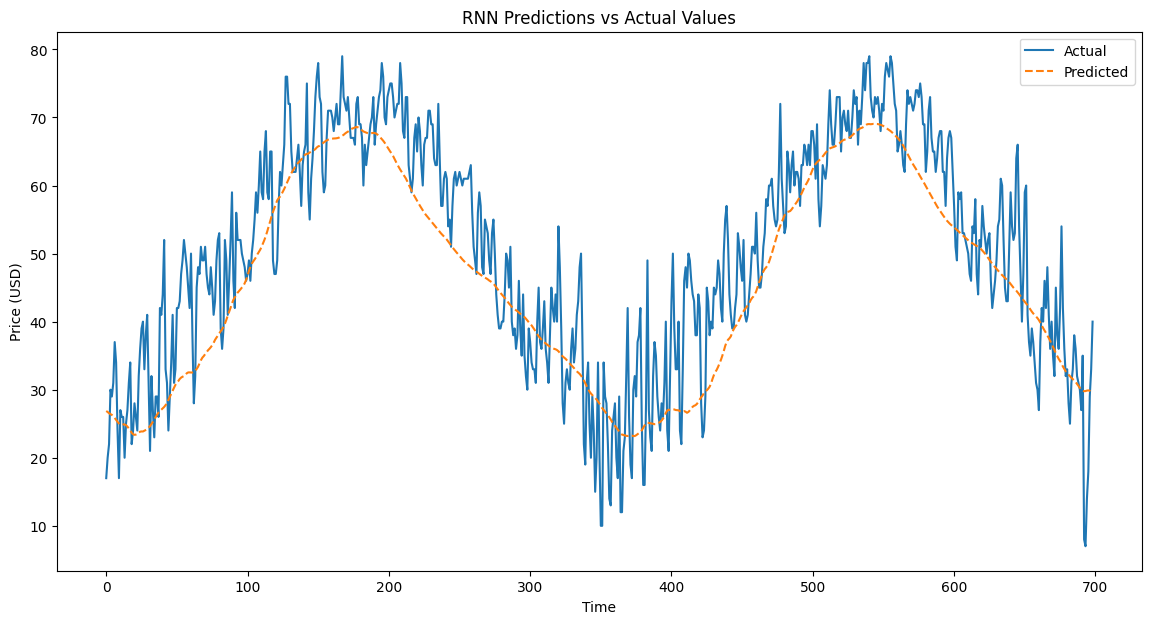

Mean Absolute Error (MAE): 6.7154
Root Mean Squared Error (RMSE): 8.3896
Mean Absolute Percentage Error (MAPE): 15.88%


In [40]:
# Test the model
trained_lstm_model.eval()
test_predictions = []
test_targets = []

with torch.no_grad():
    for inputs, targets in torch.utils.data.DataLoader(
        torch.utils.data.TensorDataset(torch.tensor(X_test, dtype=torch.float32).unsqueeze(-1), torch.tensor(y_test, dtype=torch.float32)),
        batch_size=batch_size, shuffle=False
    ):
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = trained_lstm_model(inputs)
        test_predictions.append(outputs.cpu().numpy())
        test_targets.append(targets.cpu().numpy())

# Flatten the lists
test_predictions = np.concatenate(test_predictions, axis=0)
test_targets = np.concatenate(test_targets, axis=0)

# Inverse transform the predictions and targets
test_predictions = scaler.inverse_transform(test_predictions)
test_targets = scaler.inverse_transform(test_targets)

# Print the shape of predictions and targets
print(f"Predictions shape: {test_predictions.shape}")
print(f"Targets shape: {test_targets.shape}")

# For visualization, let's use only the last prediction for each test sample
test_predictions_flat = test_predictions[:, -1]
test_targets_flat = test_targets[:, -1]

# Plot the predictions vs the real values
plt.figure(figsize=(14, 7))
plt.plot(test_targets_flat, label='Actual')
plt.plot(test_predictions_flat, label='Predicted', linestyle='--')
plt.title('RNN Predictions vs Actual Values')
plt.xlabel('Time')
plt.ylabel('Temperature')
plt.legend()
plt.show()

def calculate_metrics(y_true, y_pred):
    mae = np.mean(np.abs(y_true - y_pred))
    rmse = np.sqrt(np.mean((y_true - y_pred) ** 2))
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return mae, rmse, mape

# Calculate metrics for the test set
mae, rmse, mape = calculate_metrics(test_targets_flat, test_predictions_flat)
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")

In this section, we prepare the data to include all four time series input features for the RNN while only predicting the min temperature. We load and preprocess the datasets, converting the date columns to datetime objects and setting them as indices. We merge the datasets on the date index and normalize the combined data. We then create sequences of data to be used as inputs for the RNN. Finally, we split the data into training, validation, and test sets and define data loaders to handle the data efficiently during training and evaluation.

In [42]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, TensorDataset

# Normalize the data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(weather_df)

# Prepare the data for training the RNN with multiple inputs
def create_sequences(data, input_length, output_length):
    xs, ys = [], []
    for i in range(len(data) - input_length - output_length + 1):
        x = data[i:i+input_length]
        y = data[i+input_length:i+input_length+output_length, 2]  # Predicting the third feature (TMIN)
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

# Parameters
input_length = 360  # Last year
output_length = 60  # Forecast 2 months ahead

# Create sequences
X, y = create_sequences(scaled_data, input_length, output_length)

# Check the shape of X to ensure it has the correct number of features
print(f"Shape of X: {X.shape}")  # Should be (number of samples, input_length, number of features)

# Split the data into training, validation, and test sets
train_size = int(len(X) * 0.8)
val_size = int(len(X) * 0.1875)

X_train, y_train = X[:train_size], y[:train_size]
X_val, y_val = X[train_size:train_size + val_size], y[train_size:train_size + val_size]
X_test, y_test = X[train_size + val_size:], y[train_size + val_size:]

# Define data loaders
batch_size = 256

train_loader = DataLoader(
    TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32)),
    batch_size=batch_size, shuffle=True
)

val_loader = DataLoader(
    TensorDataset(torch.tensor(X_val, dtype=torch.float32), torch.tensor(y_val, dtype=torch.float32)),
    batch_size=batch_size, shuffle=False
)

test_loader = DataLoader(
    TensorDataset(torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.float32)),
    batch_size=batch_size, shuffle=False
)

Shape of X: (55826, 360, 4)


In this section, we instantiate and train a multi-input RNN model using the four time series as input features while predicting only the min temperature. The model architecture includes two hidden layers with 100 units each. After training, we plot the training and validation losses to monitor the model's learning progress. We then evaluate the model on the test set, inverse transform the predictions to their original scale, and calculate performance metrics (MAE, RMSE, MAPE) to assess the model's accuracy. Finally, we visualize the predicted vs. actual temperature.

Epoch 1/20, Train Loss: 0.1034, Val Loss: 0.0235
Epoch 2/20, Train Loss: 0.0196, Val Loss: 0.0143
Epoch 3/20, Train Loss: 0.0146, Val Loss: 0.0133
Epoch 4/20, Train Loss: 0.0140, Val Loss: 0.0128
Epoch 5/20, Train Loss: 0.0137, Val Loss: 0.0127
Epoch 6/20, Train Loss: 0.0134, Val Loss: 0.0123
Epoch 7/20, Train Loss: 0.0132, Val Loss: 0.0121
Epoch 8/20, Train Loss: 0.0130, Val Loss: 0.0119
Epoch 9/20, Train Loss: 0.0128, Val Loss: 0.0119
Epoch 10/20, Train Loss: 0.0122, Val Loss: 0.0112
Epoch 11/20, Train Loss: 0.0076, Val Loss: 0.0063
Epoch 12/20, Train Loss: 0.0060, Val Loss: 0.0057
Epoch 13/20, Train Loss: 0.0058, Val Loss: 0.0054
Epoch 14/20, Train Loss: 0.0056, Val Loss: 0.0056
Epoch 15/20, Train Loss: 0.0056, Val Loss: 0.0055
Epoch 16/20, Train Loss: 0.0055, Val Loss: 0.0054
Epoch 17/20, Train Loss: 0.0055, Val Loss: 0.0054
Epoch 18/20, Train Loss: 0.0055, Val Loss: 0.0052
Epoch 19/20, Train Loss: 0.0055, Val Loss: 0.0055
Epoch 20/20, Train Loss: 0.0054, Val Loss: 0.0052


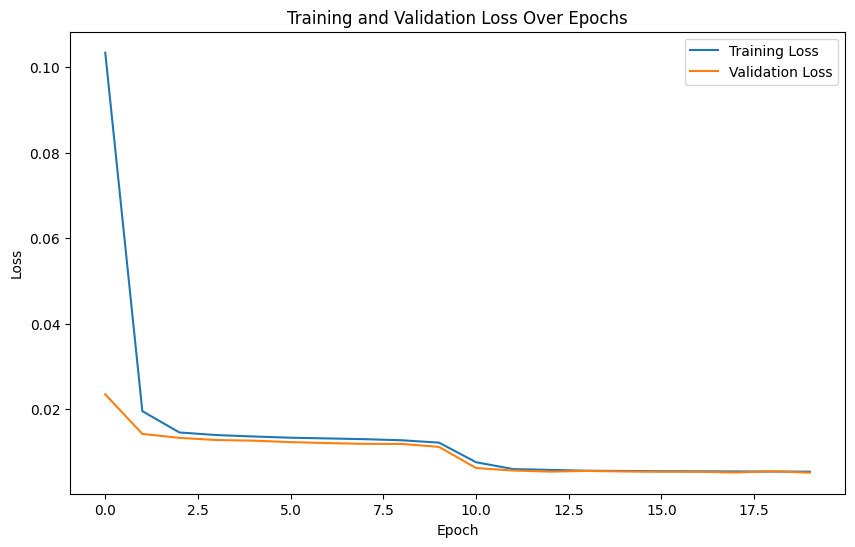

Multi-Input RNN - Mean Absolute Error (MAE): 0.4723
Multi-Input RNN - Root Mean Squared Error (RMSE): 0.5927
Multi-Input RNN - Mean Absolute Percentage Error (MAPE): 9.80%


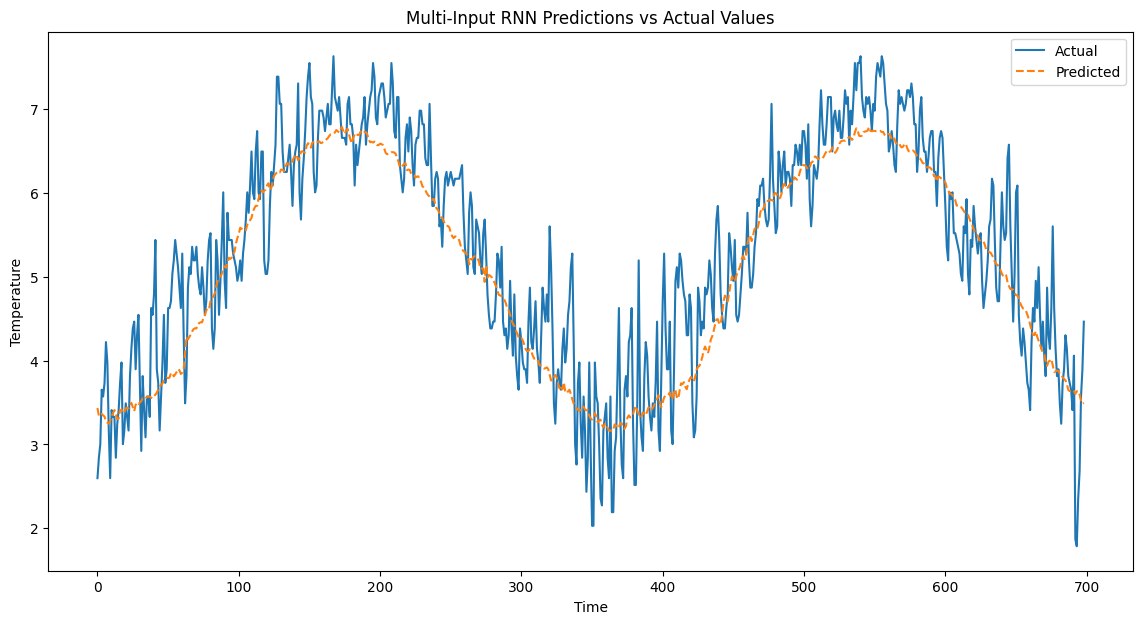

In [45]:
# Instantiate the multi-input RNN model
input_size = 4  # Four features
hidden_size = 100
num_layers = 2
output_size = 60  # Predicting 2 months ahead

multi_input_rnn_model = RNNModel(input_size, hidden_size, num_layers, output_size).to(device)

# Train the multi-input RNN model
trained_multi_input_rnn_model, train_losses, val_losses = train_model(multi_input_rnn_model,
                                                                      train_loader,
                                                                      val_loader,
                                                                      num_epochs=20,
                                                                      patience=5)

# Plot training and validation losses
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss Over Epochs')
plt.show()

# Test the multi-input RNN model
trained_multi_input_rnn_model.eval()
multi_input_rnn_test_predictions = []
multi_input_rnn_test_targets = []

with torch.no_grad():
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = trained_multi_input_rnn_model(inputs)
        multi_input_rnn_test_predictions.append(outputs.cpu().numpy())
        multi_input_rnn_test_targets.append(targets.cpu().numpy())

# Flatten the lists
multi_input_rnn_test_predictions = np.concatenate(multi_input_rnn_test_predictions, axis=0)
multi_input_rnn_test_targets = np.concatenate(multi_input_rnn_test_targets, axis=0)

# Inverse transform the predictions and targets
# Ensure the input to the scaler has the same shape as the original scaled data
multi_input_rnn_test_predictions_padded = np.zeros((multi_input_rnn_test_predictions.shape[0], scaled_data.shape[1]))
multi_input_rnn_test_predictions_padded[:, 0] = multi_input_rnn_test_predictions[:, -1]  # Only use the last prediction step for temperature

multi_input_rnn_test_targets_padded = np.zeros((multi_input_rnn_test_targets.shape[0], scaled_data.shape[1]))
multi_input_rnn_test_targets_padded[:, 0] = multi_input_rnn_test_targets[:, -1]  # Only use the last target step for temperature

# Apply inverse transform
multi_input_rnn_test_predictions_inv = scaler.inverse_transform(multi_input_rnn_test_predictions_padded)[:, 0]
multi_input_rnn_test_targets_inv = scaler.inverse_transform(multi_input_rnn_test_targets_padded)[:, 0]

# Calculate metrics for the multi-input RNN model
multi_input_rnn_mae, multi_input_rnn_rmse, multi_input_rnn_mape = calculate_metrics(multi_input_rnn_test_targets_inv, multi_input_rnn_test_predictions_inv)
print(f"Multi-Input RNN - Mean Absolute Error (MAE): {multi_input_rnn_mae:.4f}")
print(f"Multi-Input RNN - Root Mean Squared Error (RMSE): {multi_input_rnn_rmse:.4f}")
print(f"Multi-Input RNN - Mean Absolute Percentage Error (MAPE): {multi_input_rnn_mape:.2f}%")

# Plot the predictions vs the real values for the multi-input RNN
plt.figure(figsize=(14, 7))
plt.plot(multi_input_rnn_test_targets_inv, label='Actual')
plt.plot(multi_input_rnn_test_predictions_inv, label='Predicted', linestyle='--')
plt.title('Multi-Input RNN Predictions vs Actual Values')
plt.xlabel('Time')
plt.ylabel('Temperature')
plt.legend()
plt.show()